In [70]:
import numpy as np
import pickle
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import cherenkov_rings
reload(cherenkov_rings)

<module 'cherenkov_rings' from '/home/jpyanez/snoplus/snoplus_python/cherenkov_rings.pyc'>

In [71]:
import ROOT, rat

In [72]:
light_speed = 0.299792458*1000 # mm/ns

In [73]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))
pmt_radii = np.linalg.norm(pmt_info['xyz'], axis=1)
costheta = pmt_info['xyz'][:,2]/pmt_radii
phi      = np.arctan2(pmt_info['xyz'][:,1], 
                      pmt_info['xyz'][:,0])


In [74]:
effective_n = 1.4

In [83]:
pmts_ring = cherenkov_rings.PMTsInRing(effective_n = effective_n)

Using cherenkov angle 44.4153085972


In [216]:
infile_name = '/home/jpyanez/snoplus/reconstruction/jie_files/FitMPW_mode75_TresCut_Water_6MeV_10000evt_ISOFill.root'
#/home/jpyanez/snoplus/rundir/electrons_test/myelectrons.root'

In [217]:
reader.close()
reader = rat.dsreader(infile_name)
counter = 0

In [218]:
time_window_minus = 30.
time_window_plus = 50.

Selected PMTs: 86
Using time fudge factor 74.8348284126
Selected PMTs: 50
Chi2 Fit 26.7166752273
Chi2_true 25.387090979


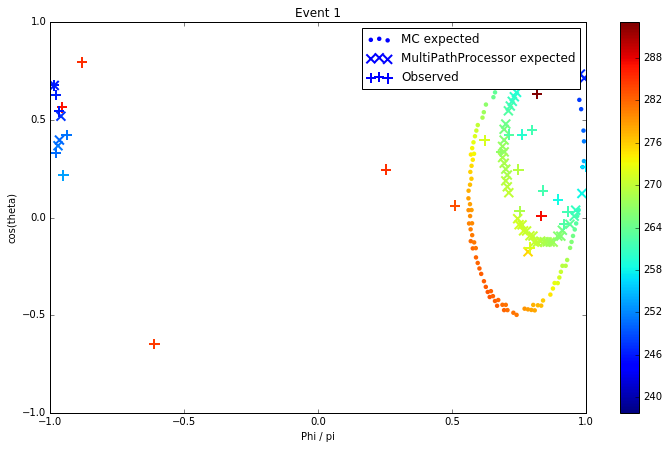

In [228]:
for ds, run in reader:
    event_bool = np.zeros_like(pmt_info['type'],dtype=bool)
    event_times = np.zeros_like(pmt_info['type'])
    
    # Assuming ONE event per trigger
    # Looping over ALL PMTs that were hit
    event = ds.GetEV(0)
    pmts  = event.GetCalPMTs()
    for iPMT in range(pmts.GetNormalCount()):
        one_pmt = pmts.GetPMT(iPMT)
        event_bool[int(one_pmt.GetID())]= True
        event_times[int(one_pmt.GetID())] = one_pmt.GetTime()
        
    
    # Selecting ONLY THOSE PMTS that are within a reasonable time window
    times_median = np.median(event_times[event_bool])
    event_bool *= ((event_times >= (times_median-time_window_minus))*
                   (event_times <= (times_median+time_window_plus)))
    
    
    # MC only info (or reconstruction)
    mc = ds.GetMC()
    mcev = ds.GetMCEV(0)
    particle = mc.GetMCParticle(0)
    e_dir = np.array(particle.GetMomentum())
    e_pos = np.array(particle.GetPosition())
    
    pmts_cone = pmts_ring(position = e_pos,
                      direction = e_dir)
    # Need to know the distance to calculate ToA and give them color
    pmt_vertex_distance = np.linalg.norm(pmt_info['xyz']- e_pos,axis=1)
    fudge = event_times[event_bool]-(particle.GetTime()+mcev.GetGTTime()+
                                     np.linalg.norm(pmt_info['xyz'][event_bool,:] - e_pos,axis=1)/(light_speed/effective_n)) 
    
    print 'Using time fudge factor', np.median(fudge)
    pmt_toa = np.median(fudge) + particle.GetTime() + mcev.GetGTTime() + pmt_vertex_distance[pmts_cone] /(light_speed/effective_n)
    
    
    # Reconstruction information
    fit = event.GetFitResult(event.GetFitNames()[0])
    vertex = fit.GetVertex(0)
    fit_vertex = np.array(vertex.GetPosition())
    fit_direction = np.array(vertex.GetDirection())
    pmts_cone_fit = pmts_ring(position = fit_vertex,
                              direction = fit_direction)
    pmt_fit_distance = np.linalg.norm(pmt_info['xyz'] - fit_vertex,axis=1)
    pmt_toa_fit = np.median(fudge) + particle.GetTime() + mcev.GetGTTime() + pmt_fit_distance[pmts_cone_fit]/(light_speed/effective_n)

    
    
    # Quick chi2 calculation
    
    # True MC information
    time_error = 2.5 # In ns
    chi2_fit  = np.sum((event_times - (vertex.GetTime() + pmt_fit_distance/(light_speed/effective_n)))[event_bool]**2)/(np.sum(event_bool)*time_error**2)
    chi2_true = np.sum((event_times - (np.median(fudge) + mcev.GetGTTime() + pmt_vertex_distance/(light_speed/effective_n)))[event_bool]**2)/(np.sum(event_bool)*time_error**2)

    print 'Chi2 Fit', chi2_fit
    print 'Chi2_true', chi2_true
    
    
    

    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    plt.scatter(phi[pmts_cone]/np.pi, costheta[pmts_cone], 
                c = pmt_toa, cmap = 'jet',
                vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10,
                marker='o',lw = 0, label = 'MC expected')
    
    plt.scatter(phi[pmts_cone_fit]/np.pi, costheta[pmts_cone_fit], 
                c = pmt_toa_fit, cmap = 'jet',
                vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, s=80,
                marker='x',lw = 2, label=event.GetFitNames()[0] + ' expected')

    plt.scatter(phi[event_bool]/np.pi, costheta[event_bool],
                c = event_times[event_bool], cmap = 'jet',
                vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, s=110,
                marker='+',lw = 2, label='Observed')
    plt.colorbar()
    
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('Phi / pi')
    plt.ylabel('cos(theta)')
    plt.legend(loc=0)
    plt.title('Event ' + "%i" % counter)
    
    plt.show()
    counter += 1
    break #raw_input()
        
#reader.close()

In [229]:
def minChiTrue(fudge = 100.):
    return np.sum((event_times - (fudge + mcev.GetGTTime() + pmt_vertex_distance/(light_speed/effective_n)))[event_bool]**2)

78.5953177258


/cvmfs/soft.computecanada.ca/easybuild/software/2017/avx2/Compiler/intel2016.4/python27-scipy-stack/2017a/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


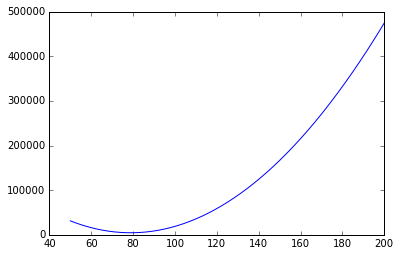

In [230]:
fudge_values = np.linspace(50, 200., 300.)
chi2_values = np.zeros_like(fudge_values)
for i,one_fudge in enumerate(fudge_values):
    chi2_values[i] = minChiTrue(one_fudge)
plt.plot(fudge_values, chi2_values)
#plt.ylim([100, 1200])
#plt.xlim([100, 120])

# Finding the minimum
min_fudge = fudge_values[chi2_values.argmin()]
print min_fudge

In [231]:
# Recalculating the chi2
time_error = 2.5 # In ns
chi2_fit  = np.sum((event_times - (vertex.GetTime() + pmt_fit_distance/(light_speed/effective_n)))[event_bool]**2)/(np.sum(event_bool)*time_error**2)
chi2_true = np.sum((event_times - (min_fudge + mcev.GetGTTime() + pmt_vertex_distance/(light_speed/effective_n)))[event_bool]**2)/(np.sum(event_bool)*time_error**2)

print 'Chi2 Fit', chi2_fit
print 'Chi2_true', chi2_true

Chi2 Fit 26.7166752273
Chi2_true 22.8370643015


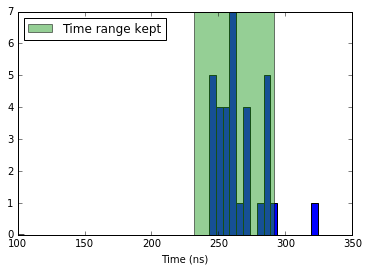

In [236]:
plt.hist(event_times, np.linspace(100, 350))
plt.axvspan(times_median-time_window_minus, 
            times_median+time_window_minus, 
            facecolor='#2ca02c', alpha=0.5, label='Time range kept')

plt.xlabel('Time (ns)')
plt.legend(loc=0)

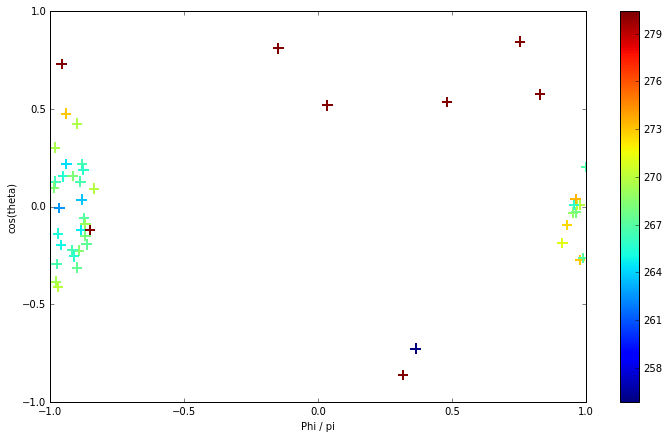

In [150]:
fig = plt.figure(figsize=(12,7))
plt.scatter(phi[event_bool]/np.pi, costheta[event_bool],
            c = event_times[event_bool], cmap = 'jet',
            vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, s=110,
            marker='+',lw = 2)
plt.colorbar()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Phi / pi')
plt.ylabel('cos(theta)')

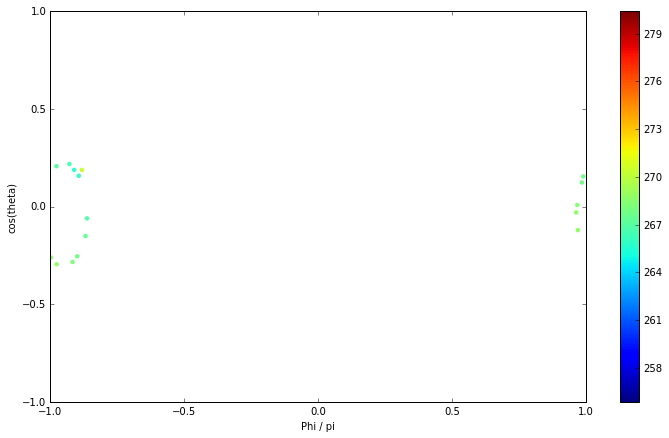

In [160]:
fig = plt.figure(figsize=(12,7))
plt.scatter(phi[pmts_cone]/np.pi, costheta[pmts_cone], 
            c = pmt_toa, cmap = 'jet',
            vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10,
            marker='o',lw = 0)
plt.colorbar()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Phi / pi')
plt.ylabel('cos(theta)')



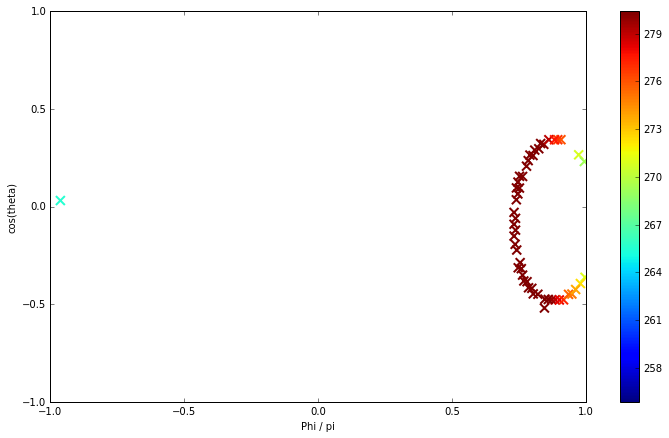

In [161]:
fig = plt.figure(figsize=(12,7))
plt.scatter(phi[pmts_cone_fit]/np.pi, costheta[pmts_cone_fit], 
            c = pmt_toa_fit, cmap = 'jet',
            vmin=pmt_toa.min()-10, vmax=pmt_toa.max()+10, s=80,
            marker='x',lw = 2)
plt.colorbar()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Phi / pi')
plt.ylabel('cos(theta)')